In [53]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model


from IPython.display import SVG
from urllib.request import urlretrieve
import zipfile
import collections

In [54]:


# Download MovieLens data.
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')


Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [55]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [30]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [31]:
users

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [34]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596
...,...,...,...,...
99995,879,475,3.0,880175444
99996,715,203,5.0,879795543
99997,275,1089,1.0,874795795
99998,12,224,2.0,882399156


In [47]:
movies.columns
# movies

Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'genre_unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'year'],
      dtype='object')

In [33]:
users

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [35]:

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [48]:
movielens.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'video_release_date', 'imdb_url', 'genre_unknown',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'age', 'sex', 'occupation', 'zip_code'],
      dtype='object')

In [37]:
min_rating = min(movielens["rating"])
max_rating = max(movielens["rating"])

train, test = train_test_split(movielens, test_size=0.1)

ROW_COUNT = train.shape[0]

EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()

UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

In [39]:
type(UNIQUE_MOVIE_IDS)

numpy.ndarray

In [16]:


def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model


model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)



callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ((test.movie_id, test.user_id),test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

# user_model.predict([np.array([10]), np.array([3])])

# model.summary()

# keras.utils.plot_model(model, show_shapes=True)



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


C:\Data\Programming\Anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
900/900 [==============================] - 1s 959us/step - loss: 1.0970 - val_loss: 0.9353
Epoch 2/50
900/900 [==============================] - 1s 808us/step - loss: 0.9558 - val_loss: 0.9417
Epoch 3/50
900/900 [==============================] - 1s 808us/step - loss: 0.9366 - val_loss: 0.9316
Epoch 4/50
900/900 [==============================] - 1s 819us/step - loss: 0.8319 - val_loss: 0.8109
Epoch 5/50
900/900 [==============================] - 1s 810us/step - loss: 0.7291 - val_loss: 0.7961
Epoch 6/50
900/900 [==============================] - 1s 811us/step - loss: 0.6886 - val_loss: 0.7887
Epoch 7/50
900/900 [==============================] - 1s 817us/step - loss: 0.6653 - val_loss: 0.7942
Epoch 8/50
900/900 [==============================] - 1s 810us/step - loss: 0.6498 - val_loss: 0.8001
Epoch 9/50
900/900 [==============================] - 1s 810us/step - loss: 0.6378 - val_loss: 0.8026
Epoch 10/50
900/900 [==============================] - 1s 810us/step - loss: 0.628

In [24]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994


In [25]:
users

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [17]:
train.head()
# len(train)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
82903,629,865,3.0,885667148,Michael (1996),25-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Michael%20(1996),0,0,...,1,0,0,0,0,1996,26,F,healthcare,55408
46118,71,653,4.0,880037461,Chinatown (1974),01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Chinatown%20(...,0,0,...,0,0,1,0,0,1974,48,F,administrator,73034
83231,886,273,1.0,881378478,Sabrina (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Sabrina%20(1995),0,0,...,1,0,0,0,0,1995,14,F,student,27249
53040,710,1045,3.0,879994367,Malice (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Malice%20(1993),0,0,...,0,0,1,0,0,1993,22,F,student,15203
47139,183,71,3.0,889909988,"Mask, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Mask,%20The%2...",0,0,...,0,0,0,0,0,1994,37,M,librarian,76013


In [18]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 10)        16820       movie_id[0][0]                   
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        9430        user_id[0][0]                    
___________________________________________________________________________________________

In [19]:
# user_model.predict([np.array([10]), np.array([3])])

In [20]:
# keras.utils.plot_model(model, show_shapes=True)

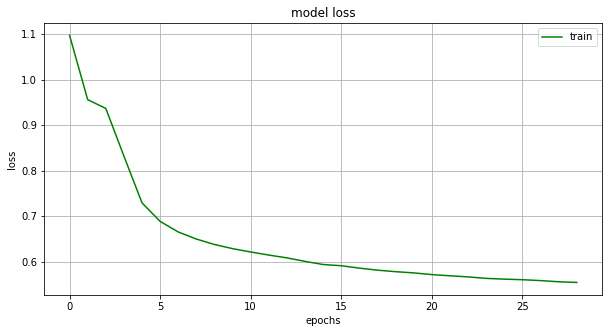

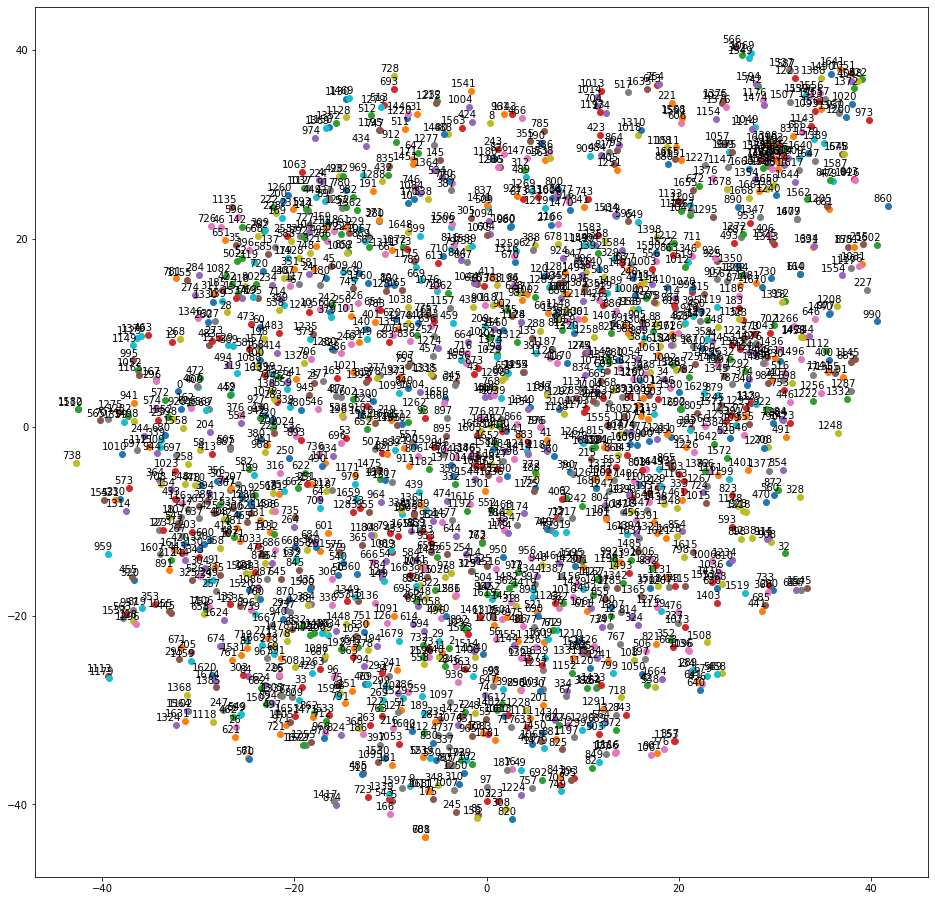

0                            Faithful (1996)
1                           Afterglow (1997)
2                                Jude (1996)
3                       Young Guns II (1990)
4                          Houseguest (1994)
5                   Starship Troopers (1997)
6    Wooden Man's Bride, The (Wu Kui) (1994)
7                           Mask, The (1994)
8                        Maximum Risk (1996)
9                          Hard Eight (1996)
Name: title, dtype: object

In [41]:


from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

TEST_USER_ID = 200
TEST_MOVIE_ID = 123

MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt




def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()


tsne_plot(model, MOVIE_EMBEDDING_LIST)



# user_model.predict([np.array([10]), np.array([3])])

knn_train_label = UNIQUE_MOVIE_IDS


from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)


def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']


user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

recommend_movies(user_embedding)


In [49]:
train

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
83016,900,120,4.0,877127219,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,...,0,1,0,1,0,1996,38,M,executive,L1V3W
68698,829,967,4.0,891898211,"Inspector General, The (1949)",01-Jan-1949,NaN,http://us.imdb.com/M/title-exact?Inspector%20G...,0,0,...,0,0,0,0,0,1949,46,M,programmer,53066
51529,789,327,3.0,884461023,Conspiracy Theory (1997),08-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Conspiracy+Th...,0,1,...,1,0,1,0,0,1997,27,M,technician,80913
40850,902,1066,2.0,891031412,Bottle Rocket (1996),21-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Bottle%20Rock...,0,0,...,0,0,0,0,0,1996,28,M,educator,20850
57933,320,174,3.0,879439706,Brazil (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Brazil%20(1985),0,0,...,0,1,0,0,0,1985,49,F,educator,55413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14765,190,338,3.0,891562090,Mad City (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Mad+City+(1997),0,1,...,0,0,0,0,0,1997,33,M,administrator,95161
60355,408,1064,2.0,881109264,Koyaanisqatsi (1983),01-Jan-1983,NaN,http://us.imdb.com/M/title-exact?Koyaanisqatsi...,0,0,...,0,0,0,1,0,1983,48,M,administrator,98225
23591,497,537,1.0,881962988,Anastasia (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Anastasia+(1997),0,0,...,0,0,0,0,0,1997,26,M,writer,55408
96503,347,236,4.0,886523078,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,...,1,0,0,0,0,1996,24,F,student,45660


In [50]:
train

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
83016,900,120,4.0,877127219,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,...,0,1,0,1,0,1996,38,M,executive,L1V3W
68698,829,967,4.0,891898211,"Inspector General, The (1949)",01-Jan-1949,NaN,http://us.imdb.com/M/title-exact?Inspector%20G...,0,0,...,0,0,0,0,0,1949,46,M,programmer,53066
51529,789,327,3.0,884461023,Conspiracy Theory (1997),08-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Conspiracy+Th...,0,1,...,1,0,1,0,0,1997,27,M,technician,80913
40850,902,1066,2.0,891031412,Bottle Rocket (1996),21-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Bottle%20Rock...,0,0,...,0,0,0,0,0,1996,28,M,educator,20850
57933,320,174,3.0,879439706,Brazil (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Brazil%20(1985),0,0,...,0,1,0,0,0,1985,49,F,educator,55413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14765,190,338,3.0,891562090,Mad City (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Mad+City+(1997),0,1,...,0,0,0,0,0,1997,33,M,administrator,95161
60355,408,1064,2.0,881109264,Koyaanisqatsi (1983),01-Jan-1983,NaN,http://us.imdb.com/M/title-exact?Koyaanisqatsi...,0,0,...,0,0,0,1,0,1983,48,M,administrator,98225
23591,497,537,1.0,881962988,Anastasia (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Anastasia+(1997),0,0,...,0,0,0,0,0,1997,26,M,writer,55408
96503,347,236,4.0,886523078,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,...,1,0,0,0,0,1996,24,F,student,45660


In [52]:
type(train.movie_id)

pandas.core.series.Series

In [ ]:
train.movie_id, train.user_id],train.rating